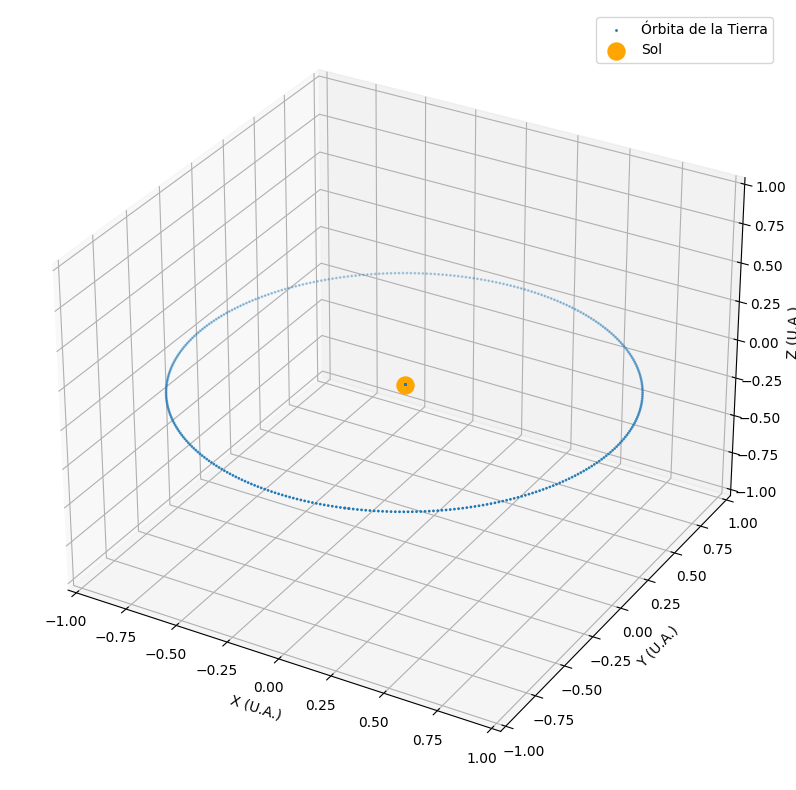

In [32]:
import numpy as np
from scipy.optimize import root_scalar
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt

# Simbolos y constantes 
"""
a = semieje mayor
e = excentricidad
omega = longitud del nodo ascendente
w = argumento del pericentro
i = inclinacion de la orbita
n = movimiento medio
lo = anomalia media en la epoca
tp = tiempo del perihelio
to = tiempo de la epoca
M = la suma de las masas de los cuerpos
"""

# Efemerides Tierra
a_tierra = (1.495582533630905E+8*u.km).to('au')
ecc_tierra = 1.694863932474438E-02
omega_tierra = 1.498625963929686E+02*u.deg
w_tierra = 3.146587763491455E+02*u.deg
i_tierra = 4.164075603038432E-03*u.deg 
n_tierra = 1.141204629731537E-05*u.deg/u.s
l0_tierra = 1.817846947871890E+02*u.deg

#Transformacion de unidades
omega_tierra = omega_tierra.to('rad')
w_tierra = w_tierra.to('rad')
i_tierra = i_tierra.to('rad')
n_tierra = n_tierra.to('rad/s')
l0_tierra = l0_tierra.to('rad')


# Ecuacion de kepler
def Kepler(E, l, ecc):
    f = E - ecc*np.sin(E) - l
    fprime = 1 - ecc*np.cos(E)
    return f, fprime


def find_iota(t, l0, n, t0,):
    return (l0 + n*(t-t0))


def find_f(e, E):
    root_term = np.sqrt( (1+e)/(1-e) )
    right_side = root_term*np.tan(E/2)
    f = 2*np.arctan(right_side)
    return f


def find_phi(f, w):
    return f+w


def find_r(a, ecc, E):
    return a*(1 - ecc*np.cos(E))


def find_xyz (r, Om, phi, i):
    x = r*(np.cos(Om)*np.cos(phi) - np.cos(i)*np.sin(Om)*np.sin(phi))
    y = r*(np.sin(Om)*np.cos(phi) + np.cos(i)*np.cos(Om)*np.sin(phi))
    z = r*(np.sin(i)*np.sin(phi))
    return (x, y, z)


def find_norm(vector):
    num = np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)
    return num

## Parámetros temporales
n_datos = (2*365)+1
t0 = Time('2023-07-09T00:00:00', scale='tdb', format = 'isot').utc
tf = Time('2024-07-09T00:00:00', scale='tdb', format = 'isot').utc
times = np.linspace(t0,tf,366)


## Plot
plot_tierra_data = np.zeros((3,n_datos))

for ii, t in enumerate(times):
    ## 1. Hallar iota
    iota_tierra = find_iota(t, l0_tierra, n_tierra, t0)


    ## 2. Solucionar la Ec. de Kepler
    # E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), bracket=[0, iota_tierra.value], method="brentq")
    E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_tierra = find_f(ecc_tierra, E_raiz_tierra)
    #print(f_tierra)


    ## 4. Hallar phi
    phi_tierra = find_phi(f_tierra, w_tierra)


    ## 5. Hallar r
    r_tierra = find_r(a_tierra, ecc_tierra, E_raiz_tierra)


    ## 6. Hallar x, y, z
    coor_tierra = find_xyz (r_tierra, omega_tierra, phi_tierra, i_tierra)
    for jj in range (3):
        plot_tierra_data[jj, ii] = coor_tierra[jj].value


## Plot de la ótbita
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(plot_tierra_data[0], plot_tierra_data[1], plot_tierra_data[2], label='Órbita de la Tierra', s=1)
ax.scatter(0, 0, 0, s=150, label='Sol', color="orange")

ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X (U.A.)')
ax.set_ylabel('Y (U.A.)')
ax.set_zlabel('Z (U.A.)')

plt.show()